### Self-Supervised Learning using Unlabeled Data

#### Part 1. Pretraining with SimCLR

In [22]:
import torch
import torchvision
from torchvision import transforms, datasets
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning
from torch.utils.data import dataset, DataLoader

In [24]:
class CIFAR10DataModule(lightning.LightningDataModule):
    def __init__(self, train_transform, test_transform, batch_size, num_workers, data_dir='./dataset/cifar-10'):
        super().__init__()
        self.data_dir = data_dir
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ])

        self.train_dataset = datasets.CIFAR10(root=self.data_dir, train=True, transform=self.train_transform, download=True)
        self.test_dataset = datasets.CIFAR10(root=self.data_dir, train=False, transform=self.test_transform, download=True)

    def setup(self, stage=None):
        self.train_dataset, self.val_dataset = dataset.random_split(dataset=self.train_dataset, lengths=[45000, 5000])

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)
    

In [25]:
# lightning.seed_everything(42)

# cifar_data = CIFAR10DataModule(data_dir='./dataset/cifar-10', batch_size=64, num_workers=4)
# cifar_data.prepare_data()
# cifar_data.setup()

Seed set to 42


TypeError: __init__() missing 2 required positional arguments: 'train_transform' and 'test_transform'

#### Create 2 augmented versions of each image

In [14]:
self_supervised_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(128),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
    torchvision.transforms.ToTensor()])

class AugumentedImages:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        return [self.transform(image), self.transform(image)]

In [26]:
cifar_data_augumented = CIFAR10DataModule(data_dir='./dataset/cifar-10', 
                                        train_transform=AugumentedImages(self_supervised_transforms), 
                                        test_transform=self_supervised_transforms, 
                                        batch_size=64, num_workers=4)
cifar_data_augumented.prepare_data()
cifar_data_augumented.setup()

Files already downloaded and verified
Files already downloaded and verified


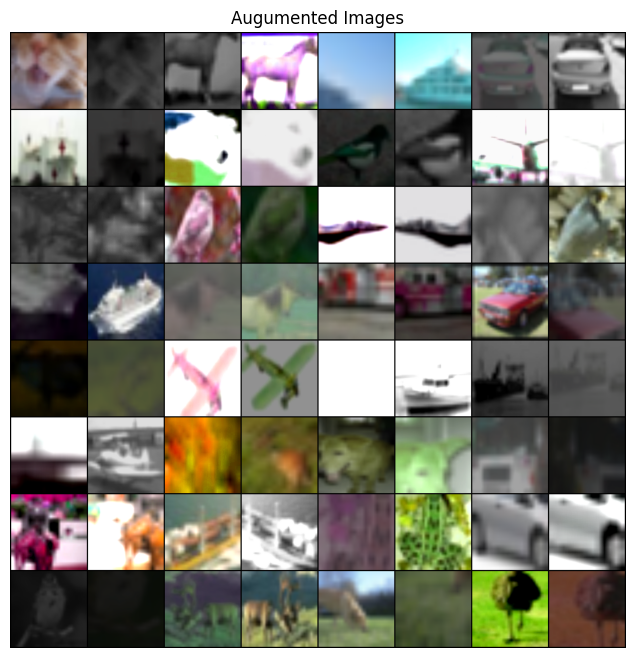

In [27]:
for images, labels in cifar_data_augumented.train_dataloader():
    break
  
paired_images = []
for i in range(32):
    paired_images.append(images[0][i])
    paired_images.append(images[1][i])

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Augumented Images')
plt.imshow(torchvision.utils.make_grid(paired_images, nrow=8).permute(1, 2, 0))
plt.show()